In [135]:
import torch
from torch_geometric.data import Data
import numpy as np
from torch_geometric.utils import dense_to_sparse
from torch_geometric.utils import to_networkx
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch_geometric
import networkx as nx
plt.style.use("dark_paper")

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(out.detach().cpu().numpy())

    fig,ax = plt.subplots(1,1,figsize=(10,10))
    plt.xticks([])
    plt.yticks([])
    plt.scatter(z[:, 0], z[:, 1], s=70, c=color,cmap="Dark2")
    return fig,ax

# 1- Node Classification 

## Dataset
To demonstrate, we make use of the Cora dataset, which is a citation network where nodes represent documents. Each node is described by a 1433-dimensional bag-of-words feature vector. Two documents are connected if there exists a citation link between them. The task is to infer the category of each document (7 in total).

In [136]:
from torch_geometric.datasets import Planetoid
from torch_geometric.transforms import NormalizeFeatures
dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

In [137]:
data = dataset[0]
print(data)
print("-"*45)
print("Training nodes:", data.train_mask.sum())
print("Node Features:", data.x.shape[1])
print("Node Classes:", dataset.num_classes)

Data(edge_index=[2, 10556], test_mask=[2708], train_mask=[2708], val_mask=[2708], x=[2708, 1433], y=[2708])
---------------------------------------------
Training nodes: tensor(140)
Node Features: 1433
Node Classes: 7


### Dense "Global" MLP

In [141]:
torch.manual_seed(12345)
mlp = torch.nn.Sequential(torch.nn.Linear(data.x.shape[1],16,bias=False),
                          torch.nn.ReLU(),
                          torch.nn.BatchNorm1d(16),
                          torch.nn.Linear(16,16),
                          torch.nn.ReLU(),
                          torch.nn.Dropout(0.1),
                          torch.nn.Linear(16,dataset.num_classes),
                         )

(<Figure size 720x720 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f0be812e410>)

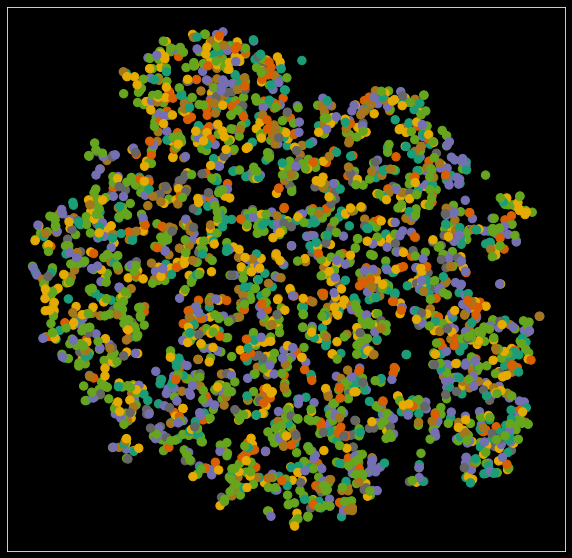

In [142]:
mlp.eval()
out = mlp(data.x)
visualize(out, color=data.y)

In [143]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(mlp.parameters(),weight_decay=5e-4,
                            lr=1e-2)
def train():
    mlp.train()
    loss = criterion(mlp(data.x[data.train_mask]), 
                     data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()
epochs = 500
for epoch in range(1,epochs):
    loss = train()
    if epoch%50==1:
        print(f"Epoch {epoch:^3d}/{epochs} | Loss {loss:^4.4f}")

Epoch  1 /500 | Loss 1.9496
Epoch 51 /500 | Loss 0.0085
Epoch 101/500 | Loss 0.0049
Epoch 151/500 | Loss 0.0039
Epoch 201/500 | Loss 0.0027
Epoch 251/500 | Loss 0.0033
Epoch 301/500 | Loss 0.0094
Epoch 351/500 | Loss 0.0033
Epoch 401/500 | Loss 0.0113
Epoch 451/500 | Loss 0.0020


Test Accuracy: 0.5680


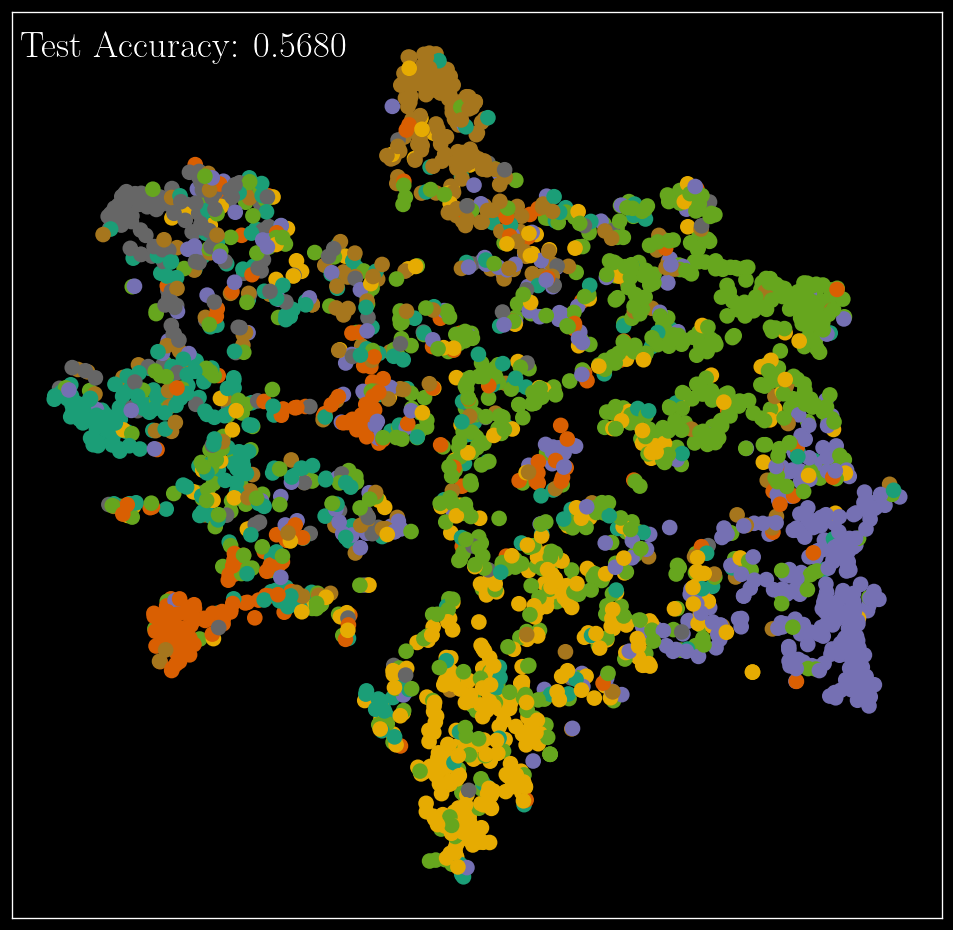

In [145]:
def test():
    mlp.eval()
    out = mlp(data.x)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')
mlp.eval()
out = mlp(data.x)
fig,ax = visualize(out, color=data.y)
ax.text(0.01,0.95,
        f"Test Accuracy: {test_acc:.4f}",transform=ax.transAxes,
       fontsize=22)
fig.set_dpi(120)
plt.show()

### Edge Conv Layer
$$
    \mathbf{X}^{\prime} = \mathbf{\hat{D}}^{-1/2} \mathbf{\hat{A}}
    \mathbf{\hat{D}}^{-1/2} \mathbf{X} \mathbf{\Theta},$$

where $$\mathbf{\hat{A}} = \mathbf{A} + \mathbf{I}$$ denotes the
adjacency matrix with inserted self-loops and
$$\hat{D}_{ii} = \sum_{j=0} \hat{A}_{ij}$$ its diagonal degree matrix.

Alternatively, we can use GraphConv:   $$\mathbf{x}^{\prime}_i = \mathbf{\Theta}_1 \mathbf{x}_i +
    \sum_{j \in \mathcal{N}(i)} \mathbf{\Theta}_2 \mathbf{x}_j.$$

In [146]:
class GCN(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = torch_geometric.nn.GCNConv(dataset.num_features, hidden_channels)
        self.conv2 = torch_geometric.nn.GCNConv(hidden_channels, hidden_channels)
        self.conv3 = torch_geometric.nn.GCNConv(hidden_channels, dataset.num_classes)
        self.batchnorm = torch.nn.BatchNorm1d(hidden_channels)
    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        #x = self.batchnorm(x)
        x = self.conv2(x, edge_index).relu()
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.conv3(x, edge_index)
        return x

In [148]:
gcn = GCN(16)

In [149]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(gcn.parameters(),weight_decay=5e-4,
                            lr=1e-2)
def train():
    gcn.train()
    out = gcn(data.x,data.edge_index)[data.train_mask]
    loss = criterion(out,
                     data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    return loss.item()
epochs = 500
for epoch in range(1,epochs):
    loss = train()
    if epoch%50==1:
        print(f"Epoch {epoch:^3d}/{epochs} | Loss {loss:^4.4f}")

Epoch  1 /500 | Loss 1.9460
Epoch 51 /500 | Loss 0.7773
Epoch 101/500 | Loss 0.2215
Epoch 151/500 | Loss 0.1466
Epoch 201/500 | Loss 0.1363
Epoch 251/500 | Loss 0.0954
Epoch 301/500 | Loss 0.1077
Epoch 351/500 | Loss 0.0869
Epoch 401/500 | Loss 0.0821
Epoch 451/500 | Loss 0.1381


Test Accuracy: 0.7450


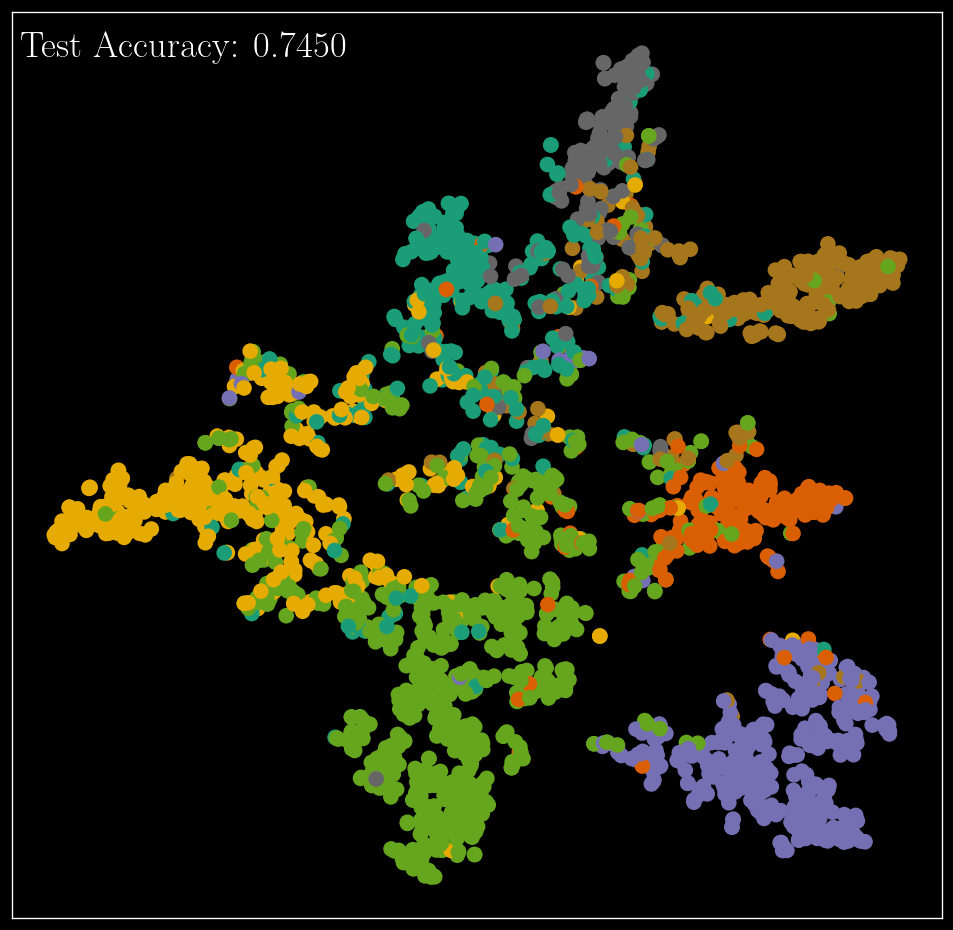

In [150]:
def test():
    gcn.eval()
    out = gcn(data.x,data.edge_index)
    pred = out.argmax(dim=1)  # Use the class with highest probability.
    test_correct = pred[data.test_mask] == data.y[data.test_mask]  # Check against ground-truth labels.
    test_acc = int(test_correct.sum()) / int(data.test_mask.sum())  # Derive ratio of correct predictions.
    return test_acc
test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')
gcn.eval()
out = gcn(data.x,data.edge_index)
fig,ax = visualize(out, color=data.y)
ax.text(0.01,0.95,
        f"Test Accuracy: {test_acc:.4f}",transform=ax.transAxes,
       fontsize=22)
fig.set_dpi(120)
plt.show()

# 2- Graph Classification 

In [151]:
def plot_graph(h, color, epoch=None, loss=None):
    fig,ax = plt.subplots(1,1,figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color,edge_color="w", cmap="Set2")
    return fig,ax

In [152]:
import torch
from torch_geometric.datasets import TUDataset

dataset = TUDataset(root='data/TUDataset', name='MUTAG')

print()
print(f'Dataset: {dataset}:')
print('====================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

data = dataset[0]  # Get the first graph object.

print()
print(data)
print('=============================================================')

# Gather some statistics about the first graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: MUTAG(188):
Number of graphs: 188
Number of features: 7
Number of classes: 2

Data(edge_attr=[38, 4], edge_index=[2, 38], x=[17, 7], y=[1])
Number of nodes: 17
Number of edges: 38
Average node degree: 2.24
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


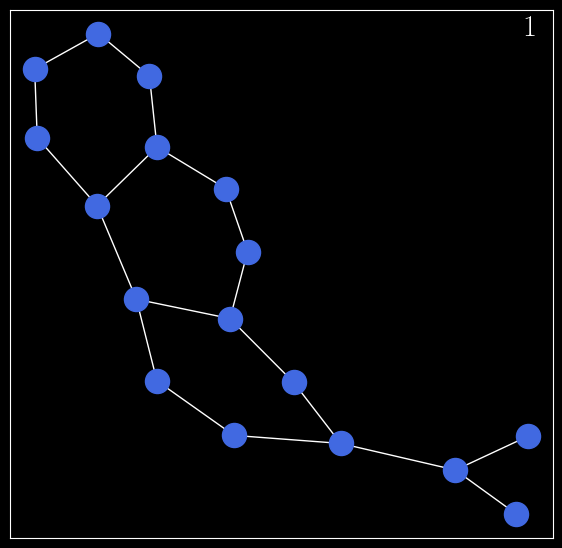

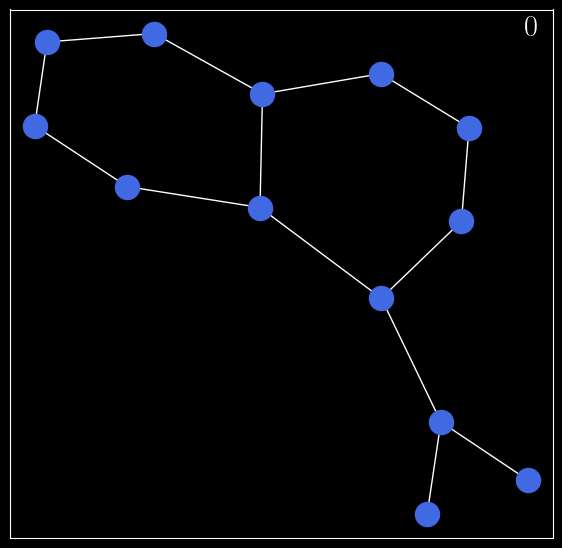

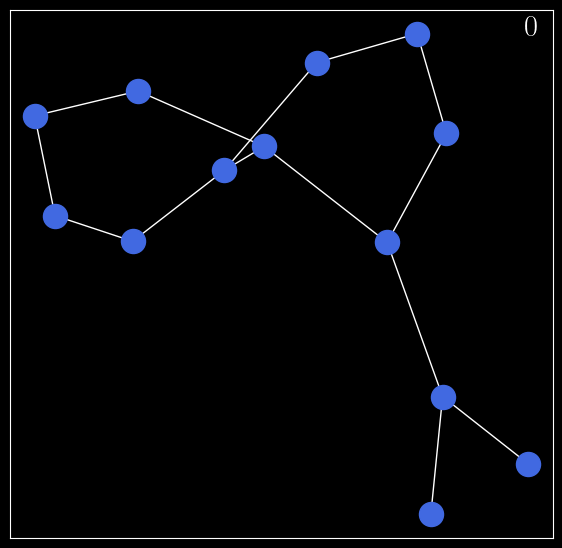

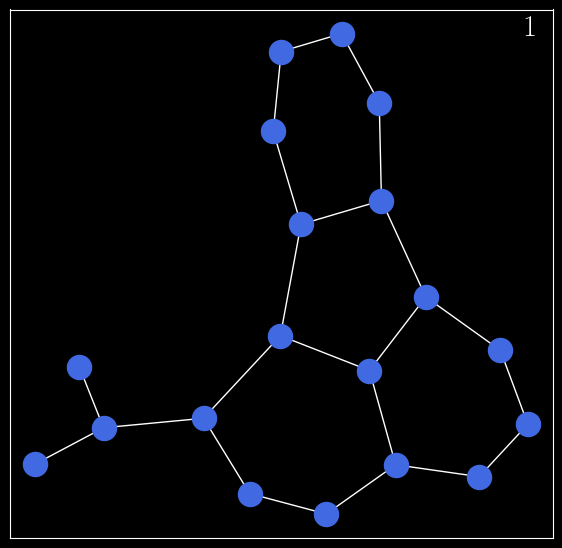

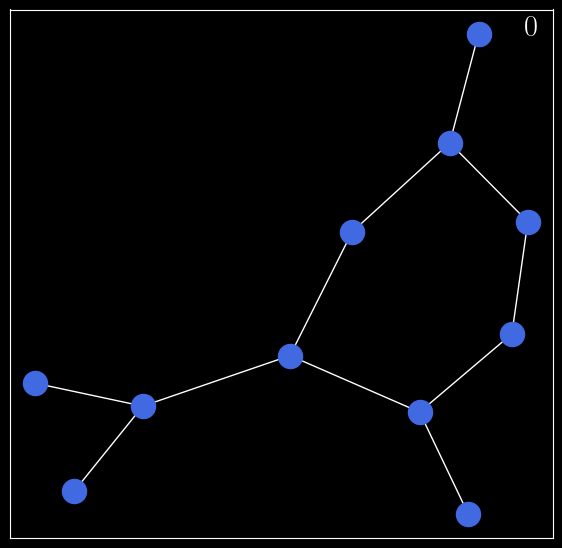

In [153]:
for i in range(5):
    data = dataset[i]
    G = to_networkx(data, to_undirected=True)
    fig,ax = plot_graph(G,color='royalblue')
    ax.text(1-0.05,0.95,
            f"{data.y.item()}",transform=ax.transAxes,
           fontsize=22)
    fig.set_dpi(100)
    plt.show()

In [117]:
from torch_geometric.data import DataLoader
torch.manual_seed(12345)
dataset = dataset.shuffle()

train_dataset = dataset[:150]
test_dataset = dataset[150:]

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [127]:
from torch_geometric.nn import global_mean_pool
class GCN_global(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(GCN_global, self).__init__()
        torch.manual_seed(12345)
        self.conv1 = torch_geometric.nn.GraphConv(dataset.num_features, hidden_channels)
        self.conv2 = torch_geometric.nn.GraphConv(hidden_channels, hidden_channels)
        self.conv3 = torch_geometric.nn.GraphConv(hidden_channels, hidden_channels)
        self.linear = torch.nn.Linear(hidden_channels,dataset.num_classes)
    def forward(self, x, edge_index,batch):
        x = self.conv1(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = self.conv2(x, edge_index).relu()
        x = global_mean_pool(x,batch)
        x = F.dropout(x, p=0.5, training=self.training)
        x = self.linear(x)
        return x
model = GCN_global(hidden_channels=64)
print(model)

GCN_global(
  (conv1): GraphConv(7, 64)
  (conv2): GraphConv(64, 64)
  (conv3): GraphConv(64, 64)
  (linear): Linear(in_features=64, out_features=2, bias=True)
)


In [128]:
model = GCN_global(hidden_channels=64)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()

def train():
    model.train()
    losses=[]
    for data in train_loader:  # Iterate in batches over the training dataset.
        out = model(data.x, data.edge_index, data.batch)  # Perform a single forward pass.
        loss = criterion(out, data.y)  # Compute the loss.
        loss.backward()  # Derive gradients.
        optimizer.step()  # Update parameters based on gradients.
        optimizer.zero_grad()  # Clear gradients.
        losses.append(loss.item())
    return np.mean(losses)
def test(loader):
    model.eval()
    correct = 0
    for data in loader:  # Iterate in batches over the training/test dataset.
        out = model(data.x, data.edge_index, data.batch)  
        pred = out.argmax(dim=1)  # Use the class with highest probability.
        correct += int((pred == data.y).sum())  # Check against ground-truth labels.
    return correct / len(loader.dataset)  # Derive ratio of correct predictions.

In [129]:
epochs = 200
for epoch in range(1, epochs+1):
    train()
    train_acc = test(train_loader)
    test_acc = test(test_loader)
    if epoch%10==0:
        print(f'Epoch: {epoch:03d}/{epochs}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

Epoch: 010/200, Train Acc: 0.7667, Test Acc: 0.8421
Epoch: 020/200, Train Acc: 0.8133, Test Acc: 0.8158
Epoch: 030/200, Train Acc: 0.8200, Test Acc: 0.7632
Epoch: 040/200, Train Acc: 0.8000, Test Acc: 0.7368
Epoch: 050/200, Train Acc: 0.8400, Test Acc: 0.7632
Epoch: 060/200, Train Acc: 0.8000, Test Acc: 0.8158
Epoch: 070/200, Train Acc: 0.8933, Test Acc: 0.7895
Epoch: 080/200, Train Acc: 0.9067, Test Acc: 0.7895
Epoch: 090/200, Train Acc: 0.9333, Test Acc: 0.8684
Epoch: 100/200, Train Acc: 0.8867, Test Acc: 0.8158
Epoch: 110/200, Train Acc: 0.9333, Test Acc: 0.8158
Epoch: 120/200, Train Acc: 0.9400, Test Acc: 0.8158
Epoch: 130/200, Train Acc: 0.9333, Test Acc: 0.8158
Epoch: 140/200, Train Acc: 0.9400, Test Acc: 0.8158
Epoch: 150/200, Train Acc: 0.9400, Test Acc: 0.8158
Epoch: 160/200, Train Acc: 0.9333, Test Acc: 0.8158
Epoch: 170/200, Train Acc: 0.9467, Test Acc: 0.7895
Epoch: 180/200, Train Acc: 0.9400, Test Acc: 0.8158
Epoch: 190/200, Train Acc: 0.9533, Test Acc: 0.8158
Epoch: 200/2

# 3- Point Cloud Classification